In [1]:
%matplotlib inline
import json
import os


import numpy as np
import cv2

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib import colors
from mpl_toolkits.mplot3d import Axes3D

### Load example document

Image shape: (3504, 2479, 3)


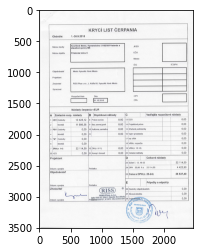

In [94]:
document_file_name = "../data/documents/stamps/faktúra.pdf-2.jpg"

image: np.ndarray = cv2.imread(document_file_name)


print(f"Image shape: {image.shape}")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_image)
plt.show()

### Downscale image
1024 should be the size of the larger axis

use nearest interpolation

Image shape: (1024, 724, 3)


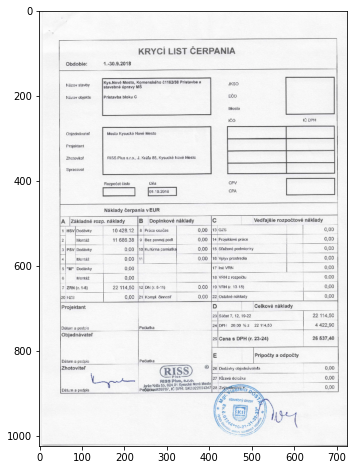

In [3]:
MAX_PIXEL_SIZE = 1024
larger_axis_size = max(image.shape[0], image.shape[1])
if larger_axis_size > MAX_PIXEL_SIZE:
    scale_factor = MAX_PIXEL_SIZE / larger_axis_size
    image = cv2.resize(image, dsize=None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_NEAREST)

print(f"Image shape: {image.shape}")
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.figure(figsize = (8, 8))
plt.imshow(rgb_image)
plt.show()

### Separate background from foreground

use Otsu's adaptive thresholding (more information here: https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_thresholding/py_thresholding.html)

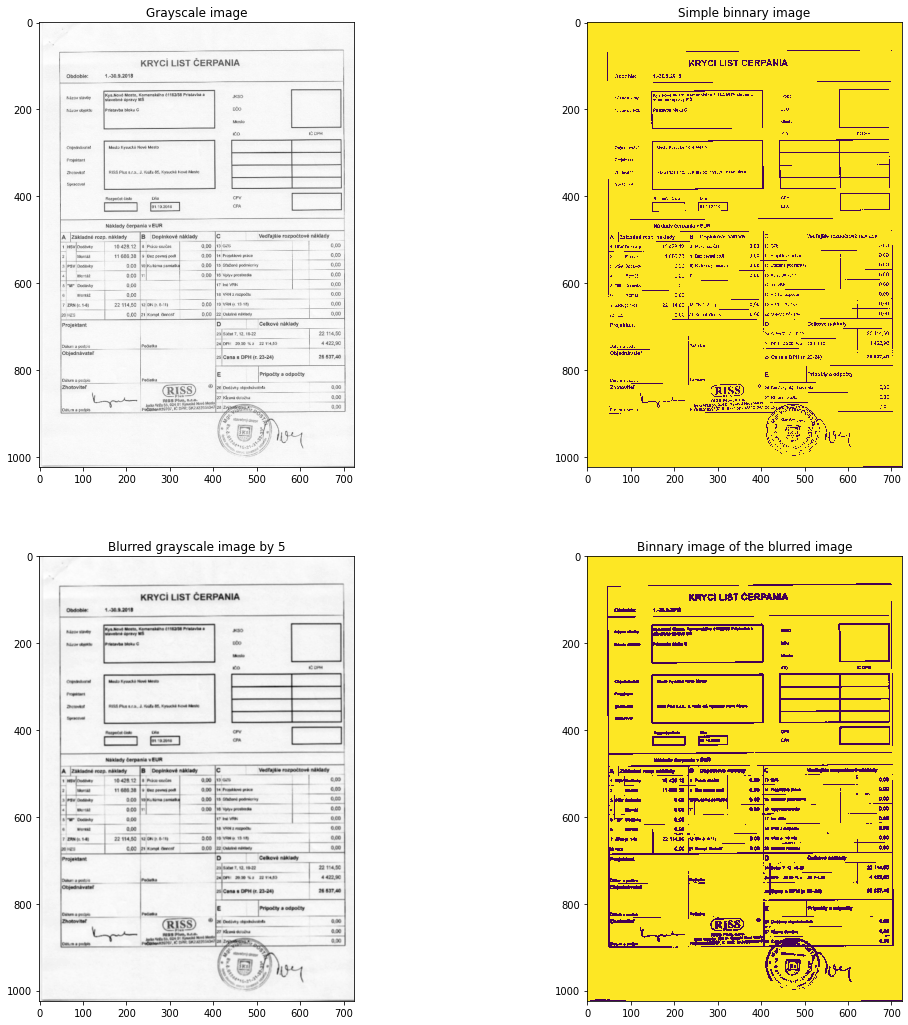

In [4]:
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

# Otsu's thresholding
threshold_1, binary_image_1 = cv2.threshold(grayscale_image, 
                                         0, 255, 
                                         cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Otsu's thresholding after Gaussian filtering
BLUR_AMOUNT = 5
blurred_image = cv2.GaussianBlur(grayscale_image, (BLUR_AMOUNT, BLUR_AMOUNT), 0)
threshold_2, binary_image_2 = cv2.threshold(blurred_image,
                                             0, 255,
                                             cv2.THRESH_BINARY + cv2.THRESH_OTSU)

def visualize_bf_fg_separation(gs_img, bin_img, blur_img, blur_bin_img):
    FIG_SIZE_INCHES = 18
    fig, axs = plt.subplots(2, 2)
    fig.set_size_inches(FIG_SIZE_INCHES, FIG_SIZE_INCHES)
    axs[0, 0].imshow(gs_img, 'gray')
    axs[0, 0].set_title("Grayscale image")
    axs[0, 1].imshow(bin_img, interpolation="none")
    axs[0, 1].set_title("Simple binnary image")
    axs[1, 0].imshow(blur_img, 'gray')
    axs[1, 0].set_title(f"Blurred grayscale image by {BLUR_AMOUNT}")
    axs[1, 1].imshow(blur_bin_img, interpolation="none")
    axs[1, 1].set_title(f"Binnary image of the blurred image")
    plt.show()

visualize_bf_fg_separation(grayscale_image, binary_image_1,
                           blurred_image, binary_image_2)

# select the first simple approach for next steps
binary_image = binary_image_1

### Color analysis
look for differences in colors in the foreground layer

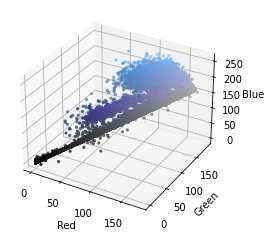

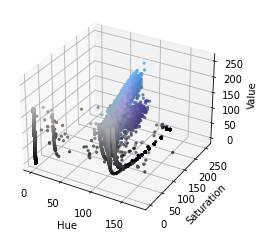

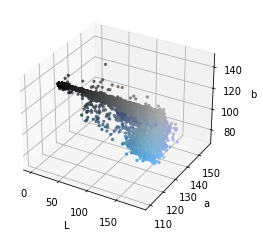

In [5]:

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)

def create_1d_foreground_image(img, bin_img):
    """Extract only the foreground pixels and create one-dimensional
    image containing all pixel channels.
    :return image of hape (n_pixels_in_foreground, 1, n_channels)"""
    result = img[bin_img == 0, :]
    return result.reshape(result.shape[0], 1, result.shape[1])

def visualize_color_distribution(img, pixel_colors, axis_names):
    h, s, v = cv2.split(img)
    fig = plt.figure()
    axis = fig.add_subplot(1, 1, 1, projection="3d")
    

    axis.scatter(h.flatten(), s.flatten(), v.flatten(), facecolors=pixel_colors, marker=".")
    axis.set_xlabel(axis_names[0])
    axis.set_ylabel(axis_names[1])
    axis.set_zlabel(axis_names[2])
    plt.show()

rgb_fg_pixel_img = create_1d_foreground_image(rgb_image, binary_image)
hsv_fg_pixel_img = create_1d_foreground_image(hsv_image, binary_image)
lab_fg_pixel_img = create_1d_foreground_image(lab_image, binary_image)
    
pixel_colors = rgb_fg_pixel_img.reshape((np.shape(rgb_fg_pixel_img)[0] * np.shape(rgb_fg_pixel_img)[1], 3))
norm = colors.Normalize(vmin=-1.,vmax=1.)
norm.autoscale(pixel_colors)
pixel_colors = norm(pixel_colors).tolist()
    
visualize_color_distribution(rgb_fg_pixel_img, pixel_colors, ("Red", "Green", "Blue"))
visualize_color_distribution(hsv_fg_pixel_img, pixel_colors, ("Hue", "Saturation", "Value"))
visualize_color_distribution(lab_fg_pixel_img, pixel_colors, ("L", "a", "b"))

### Clustering
try to detect blobs of objects using the kmeans clustering method

the observation consists of three features: pixel location x, pixel location y and pixel HUE

In [9]:
from sklearn.cluster import KMeans


Total within cluster cost is 7701.606585575137


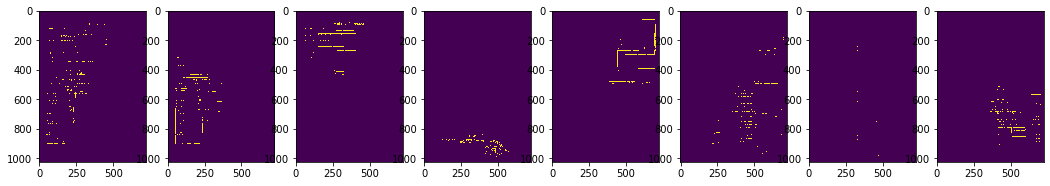

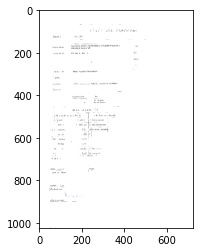

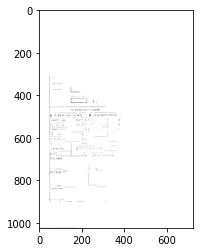

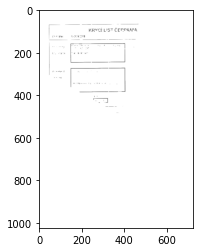

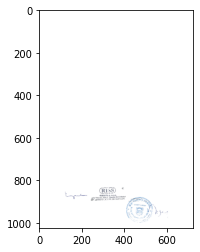

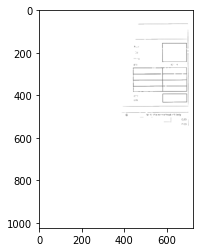

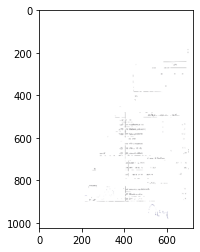

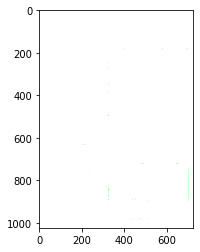

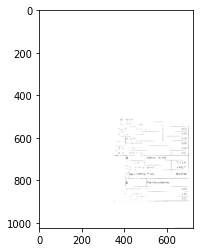

In [90]:

def cluster_image(image, bin_image, n_clusters = 3, color_weight = 1.):
    
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    
    pixel_locations = np.argwhere(bin_image == 0)
    
    # extract hue from HSV image at pixel locations
    pixel_colors = hsv_image[pixel_locations[:, 0],
                             pixel_locations[:, 1], :1]
    
    # observations of shape (n, 3)
    observations = np.hstack((pixel_locations, pixel_colors)).astype(np.float64)
    # normalize
    observations[:, 0] = observations[:, 0] / bin_image.shape[0]
    observations[:, 1] = observations[:, 1] / bin_image.shape[1]
    observations[:, 2] = (observations[:, 2] / 255) * color_weight
    
    kmeans = KMeans(n_clusters=n_clusters,
                    init="k-means++",
                    random_state=42)
    
    kmeans_output = kmeans.fit(observations)
    
    cluster_images = []
    total_cost = 0.
    
    for i in range(n_clusters):
        
        # create binary image of i-th cluster
        binary_cluster_image = np.full_like(bin_image, fill_value=0)
        cluster_mask = kmeans_output.labels_ == i
        cluster_observations = observations[cluster_mask]
        locations = pixel_locations[cluster_mask]
        binary_cluster_image[locations[:, 0], locations[:, 1]] = 255
        cluster_images.append(binary_cluster_image)
        
        # calculate within cluster cost
        cluster_center = kmeans.cluster_centers_[i]
        costs = np.linalg.norm(cluster_observations - cluster_center, axis=1)
        total_cost += np.sum(costs)
    
    print(f"Total within cluster cost is {total_cost}")
    
    return cluster_images

def visualize_cluster_images(bin_images):
    FIG_SIZE_INCHES = 18
    fig, axs = plt.subplots(1, len(bin_images))
    fig.set_size_inches(FIG_SIZE_INCHES, FIG_SIZE_INCHES)
    
    for i, bin_image in enumerate(bin_images):
        axs[i].imshow(bin_image, interpolation="none")
    plt.show()
    

def visualize_cluster_images_in_color(bin_images, rgb_image):
    for i, bin_image in enumerate(bin_images):
        extracted_image = rgb_image.copy()
        extracted_image[bin_image == 0, :] = (255, 255, 255)
        plt.figure(figsize = (4, 4))
        plt.imshow(extracted_image)
        plt.show()

cluster_images = cluster_image(image, binary_image, 8, 8.)

visualize_cluster_images(cluster_images)

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
visualize_cluster_images_in_color(cluster_images, rgb_image)


### Bordering
Using contours to mark borders in the original image

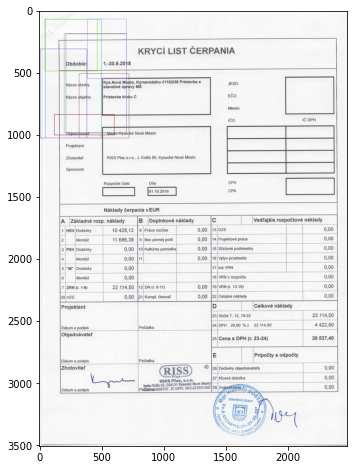

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)]

In [99]:
import random

bboxes = []



for cluster_image in cluster_images:
    contours, hierarchy = cv2.findContours(cluster_image,
                                           cv2.RETR_EXTERNAL,
                                           cv2.CHAIN_APPROX_SIMPLE)
    bboxes.append(cv2.boundingRect(cluster_image))

bordered_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

for bbox in bboxes:
    x, y, w, h = bbox
    random_color = (random.randint(0, 256), random.randint(0, 256), random.randint(0, 256))
    bordered_image = cv2.rectangle(bordered_image, 
                                   (x,y), # top left
                                   (x + w, y + h), # bottom right
                                   random_color,  # color 
                                   2)  # 2 pixel thick
    

plt.figure(figsize = (8, 8))
plt.imshow(bordered_image)
plt.show()

tab_colors = [colors.to_rgb(x) for x in colors.TABLEAU_COLORS.values()]
tab_colors
